<p style="text-align: center;"><span style="color: #ff0000;"><strong><span style="font-size: x-large;">
    ANEXO III: PROBLEMAS RELACIONADOS CON RETICULOS</span></strong></span></p>

<p style="text-align: center;"><span style="color: black;"><strong><span style="font-size: x-large;">Realizado por:</span></strong></span></p>
<p style="text-align: center;"><span style="color: black;"><strong><span style="font-size: x-large;">Gabriel Vacaro Goytia</span></strong></span></p>
<p style="text-align: center;"><span style="color: black;"><strong><span style="font-size: x-large;">Ignacio Warleta Murcia</span></strong></span></p>

Después de comprender en detalle los fundamentos matematicos sobre los cuales se construye el esquema criptografico KYBER-KEM y de haber analizado cuidadosamente los problemas relacionados más relevantes que sustentan su seguridad, en este anexo procederemos a estudiar su funcionameinto de manera detallada, explicando paso a paso cada una de las fases que lo componen. En concreto, en este anexo, se han desarrollado implementaciones para ilustrar los problemas relacionados con retículos, como son el CVP, el SVP y el LWE. Para ello se ha hecho uso de la librería LattPy, utilizada y explicada en el anexo II.

Organizamos el anexo según el siguiente índice:

# Índice

1. [Introducción](#1.-Introducción)
2. [Configuración previa](#2.-Configuración-previa)
3. [Problema del vector mas cercano](#3.-CVP)
4. [Problema del vector mas corto](#4.-SVP)
5. [Aprendizaje con errores](#5.-LWE)

---
# 1. Introducción


En este anexo se presentan las implementaciones prácticas de tres problemas fundamentales en el ámbito de la criptografía post-cuántica: el Problema del Vector Más Cercano (**CVP**, por sus siglas en inglés), el Problema del Vector Más Corto (**SVP**) y el Problema de Aprendizaje con Errores (**LWE**). Estos problemas son pilares matemáticos sobre los que se construyen diversos esquemas criptográficos modernos debido a su elevada complejidad computacional y a su resistencia frente a ataques con computadoras cuánticas. A lo largo de este anexo, se detalla cómo se han implementado estos problemas, proporcionando un análisis del diseño de los algoritmos, los métodos de optimización utilizados y los resultados obtenidos en diferentes escenarios prácticos. 



# 2. Configuración previa

In [1]:
#MODULOS A IMPORTAR
import numpy as np
import lattpy as lp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
import time  # Importar time para medir el tiempo

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
#FUNCIONES UTILIZADAS

def crear_atomos(latt, num_atoms, dimensiones=7):
    """
    Crea átomos en la red con posiciones aleatorias y únicas.
    
    Parámetros:
    latt: objeto de la red donde se agregarán los átomos.
    num_atoms: número de átomos a crear.
    dimensiones: número de dimensiones del espacio (por defecto 7).

    Retorna:
    None
    """
    # Crear un conjunto para asegurarnos de que las posiciones sean únicas
    posiciones_generadas = set()

    while len(posiciones_generadas) < num_atoms:
        # Generar coordenadas aleatorias en [0, 1] para todas las dimensiones
        coords = tuple(np.random.rand(dimensiones))  # np.random.rand genera valores en [0, 1)
        posiciones_generadas.add(coords)  # Añadir a un conjunto asegura unicidad

    # Agregar átomos únicos a la red
    for i, coords in enumerate(posiciones_generadas):
        nombre = f"Atom_{i + 1}"  # Nombra los átomos de forma automática
        latt.add_atom(list(coords), nombre)

# Función para generar los puntos del retículo
def generar_puntos_reticulo(base, limite):
    """
    Genera todos los puntos del retículo dados los vectores base y un límite de los enteros.

    base: matriz de base (n x n) que genera el retículo.
    limite: rango de los valores enteros para las combinaciones.

    Retorna un array con todos los puntos del retículo.
    """
    # Generamos todas las combinaciones posibles de los enteros para k1, k2, ..., kn
    posibles_k = list(product(range(-limite, limite + 1), repeat=base.shape[0]))

    # Generamos los puntos del retículo como combinaciones lineales de los vectores base
    puntos_reticulo = []
    for k in posibles_k:
        punto = sum(k[i] * base[i] for i in range(len(k)))
        puntos_reticulo.append(punto)
    
    return np.array(puntos_reticulo)



#Funcion para calcular el vector mas cercano dado un punto
def closestVector(base, limite, puntos_reticulo, target_point):
    """
    Encuentra el vector más cercano desde un punto objetivo (target_point) a todos los puntos del retículo.
    
    base: matriz de base del retículo.
    limite: rango de los índices.
    puntos_reticulo: arreglo con los puntos del retículo generados.
    target_point: punto objetivo desde el cual buscar el vector más cercano.
    
    Retorna el vector más cercano y su norma.
    """
    
    # Inicializar variables para almacenar el mejor vector y su norma más baja
    mejor_vector = None
    menor_norma = float('inf')

    # Iterar sobre todos los puntos del retículo
    for punto in puntos_reticulo:
        if not np.array_equal(punto, target_point):  # Evitar el propio punto objetivo
            vector = punto - target_point  # Vector entre el punto objetivo y el punto del retículo
            norma = np.linalg.norm(vector)  # Calcular la norma del vector

            # Si encontramos un vector con norma menor, lo actualizamos
            if norma < menor_norma:
                mejor_vector = vector
                menor_norma = norma
    
    return mejor_vector, menor_norma


# Función para calcular el vector más corto entre todos los puntos del retículo
def shortestVector(base, limite, puntos_reticulo):
    """
    Encuentra el vector más corto entre todos los puntos del retículo generado por los vectores base,
    excluyendo el origen. Considera todas las combinaciones posibles de pares de puntos.

    base: matriz de base del retículo.
    limite: rango de los índices.

    Retorna el vector más corto y su norma.
    """
    
    # Inicializar variables para almacenar el mejor vector y su norma más baja
    mejor_vector = None
    menor_norma = float('inf')

    # Iterar sobre todos los pares de puntos posibles
    for i, punto_1 in enumerate(puntos_reticulo):
        for j, punto_2 in enumerate(puntos_reticulo):
            if i != j:  # Evitar calcular el vector entre un punto y él mismo
                vector = punto_2 - punto_1  # Vector entre el par de puntos
                norma = np.linalg.norm(vector)  # Calcular la norma del vector
                
                # Si encontramos un vector con norma menor, lo actualizamos
                if norma < menor_norma:
                    mejor_vector = vector
                    menor_norma = norma
    
    return mejor_vector, menor_norma




---

# 3. CVP

En un retículo $L$, el problema del vector más cercano consiste en encontrar un vector $v∈L$ que esté más cerca de un punto dado $t∈R^n$ en términos de la norma euclidiana. Formalmente, se busca: 

Encontrar $ v \in L $ que minimice $|v - t|$, siendo:  $v = \arg\min_{w \in L} \|w - t\|.$

En esta implementación, veremos de forma gráfica tanto en 2D como en 3D como se comporta este problema, en caso de querer variar los parámetros, basta con cambiar las variables iniciales:

- num_atoms: determina cuantas redes se formarán (Gran impacto en rendimiento)

- dimensiones: determina el tamaño de la matriz base (Gran impacto en rendimiento, mantener por debajo de 8).

- target_point: determina el punto sobre el que buscar el vector mas cercano

- limite: determina los valores máximos en cada eje (Gran impacto en rendimiento).

- num_conex: determina el numero de conexiones de cada punto del retículo, por ejemplo, si equivale a 2, se conectara a sus dos vecinos más cercanos (Gran impaco en rendimiento).


Por otra parte, el último bloque de código no presenta visualización, pues esta pensado para probar en dimensiones mayores que no pueden ser representadas graficamente, no obstante si presenta una salida con los valores solución del problema.

Coordenadas del punto más cercano desde el punto objetivo [6 6]: [5. 5.]
Coordenadas del vector más cercano desde el punto objetivo [6 6]: [-1., -1.]
Norma del vector más cercano: 1.41
Tiempo para encontrar el vector más cercano: 0.00205 segundos


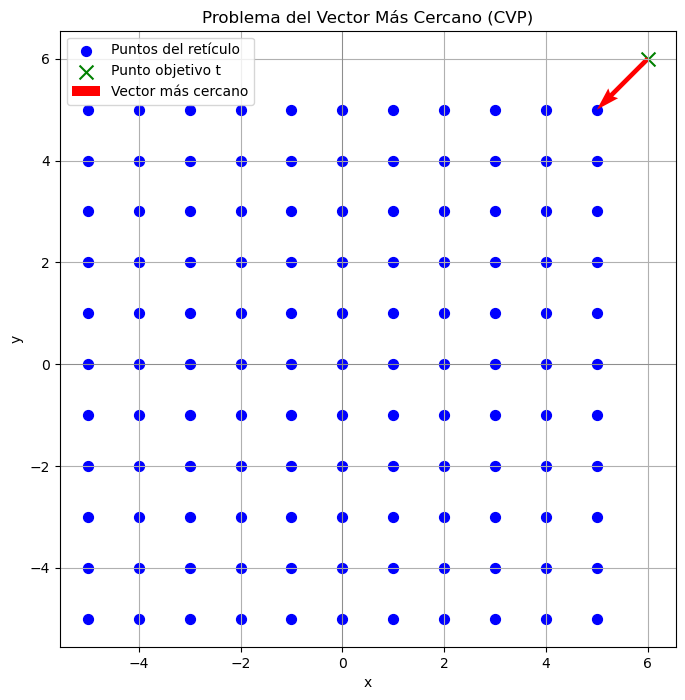

In [26]:
# PROBLEMA DEL CVP 2D

#VARIABLES
num_atoms = 1
dimensiones = 2
target_point = np.array([6,6])  # Punto sobre el que buscar el vector mas cercano
limite = 5
num_conex = 1

# Crear el retículo con lattpy
base = np.eye(dimensiones)  # Matriz identidad para generar base genérica
latt = lp.Lattice(base)
crear_atomos(latt, num_atoms, dimensiones)
latt.add_connections(num_conex)  # Conexión de primer vecino

# Construir un retículo finito de tamaño 5x5
latt.build((limite, limite))

# Generar puntos del retículo
puntos_reticulo = generar_puntos_reticulo(base, limite)

# Temporizador: Medir solo el tiempo de encontrar el vector más cercano
start_time = time.time()
closest_vector, closest_norm = closestVector(base, limite, puntos_reticulo, target_point)
end_time = time.time()

closest_point =  target_point + closest_vector

# Imprimir el vector más cercano con todas las coordenadas
print(f"Coordenadas del punto más cercano desde el punto objetivo {target_point}: {closest_point}")
print(f"Coordenadas del vector más cercano desde el punto objetivo {target_point}: {np.array2string(closest_vector, separator=', ')}")
print(f"Norma del vector más cercano: {closest_norm:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más cercano
print(f"Tiempo para encontrar el vector más cercano: {end_time - start_time:.5f} segundos")

# Visualización
plt.figure(figsize=(8, 8))

# Puntos del retículo
plt.scatter(puntos_reticulo[:, 0], puntos_reticulo[:, 1], c="blue", label="Puntos del retículo", s=50)  # Aumentar tamaño de los puntos

# Punto objetivo t
plt.scatter(target_point[0], target_point[1], c="green", label="Punto objetivo t", s=100, marker="x")  # Diferenciar el punto objetivo

# Vector más cercano (ajustar la escala)
# La flecha va desde target_point hasta closest_point
plt.quiver(target_point[0], target_point[1], closest_point[0] - target_point[0], closest_point[1] - target_point[1],
           angles='xy', scale_units='xy', scale=1, color="red", label="Vector más cercano")  # Ajuste la escala para la visualización

# Líneas de referencia para los ejes
plt.axhline(0, color="gray", lw=0.5)
plt.axvline(0, color="gray", lw=0.5)

# Configurar la vista para que la relación de aspecto sea igual (para que los ejes no distorsionen)
plt.gca().set_aspect('equal', adjustable='box')

# Agregar leyenda y título
plt.legend()
plt.title("Problema del Vector Más Cercano (CVP)")
plt.xlabel("x")
plt.ylabel("y")

# Mostrar la cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()


Coordenadas del punto más cercano desde el punto objetivo [6 6 6]: [5. 5. 5.]
Coordenadas del vector más cercano desde el punto objetivo [6 6 6]: [-1., -1., -1.]
Norma del vector más cercano: 1.73
Tiempo para encontrar el vector más cercano: 0.01383 segundos


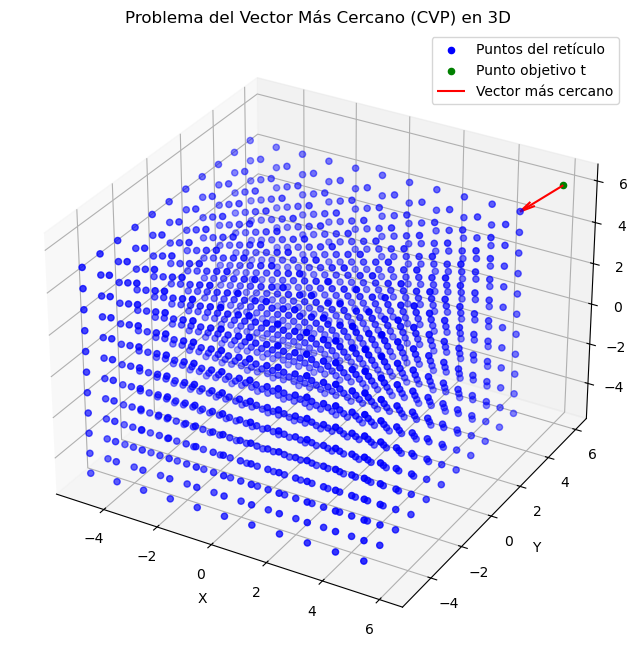

In [27]:
# PROBLEMA DEL CVP 3D
num_atoms = 1
dimensiones = 3
target_point = np.array([6, 6, 6])  # Punto sobre el que buscar el vector más cercano
limite= 5
num_conex = 1

# Crear el retículo con lattpy
base = np.eye(dimensiones)  # Matriz identidad para generar base genérica
latt = lp.Lattice(base)
crear_atomos(latt, num_atoms, dimensiones)
latt.add_connections(num_conex)  # Conexión de primer vecino

# Construir un retículo finito de tamaño 5x5x5 (en 3D)
latt.build((limite, limite, limite))

# Generar puntos del retículo
puntos_reticulo = generar_puntos_reticulo(base, limite)

# Temporizador: Medir solo el tiempo de encontrar el vector más cercano
start_time = time.time()
closest_vector, closest_norm = closestVector(base, limite, puntos_reticulo, target_point)
# Fin del temporizador
end_time = time.time()

# Calcular el punto más cercano
closest_point = target_point + closest_vector

# Imprimir el vector más cercano con todas las coordenadas
print(f"Coordenadas del punto más cercano desde el punto objetivo {target_point}: {closest_point}")
print(f"Coordenadas del vector más cercano desde el punto objetivo {target_point}: { np.array2string(closest_vector, separator=', ')}")
print(f"Norma del vector más cercano: {closest_norm:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más cercano
print(f"Tiempo para encontrar el vector más cercano: {end_time - start_time:.5f} segundos")

# Visualización en 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Puntos del retículo
ax.scatter(puntos_reticulo[:, 0], puntos_reticulo[:, 1], puntos_reticulo[:, 2], c="blue", label="Puntos del retículo")  # Puntos del retículo
ax.scatter(target_point[0], target_point[1], target_point[2], c="green", label="Punto objetivo t")  # Punto objetivo t

# Vector más cercano
ax.quiver(target_point[0], target_point[1], target_point[2], 
          closest_point[0] - target_point[0], closest_point[1] - target_point[1], closest_point[2] - target_point[2],
          color="red", label="Vector más cercano", length=closest_norm, normalize=True)

# Configurar el gráfico
ax.set_aspect('auto')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.set_title("Problema del Vector Más Cercano (CVP) en 3D")
plt.show()


In [29]:
#PROBLEMA DEL CVP GENERALIZADO

# VARIABLES ( Importante que las coordenadas del punto objetivo se ajusten a las dimensiones)
dimensiones = 4
num_atomos = 1
num_conex = 1
limite = 2  
#¡Tiene que coincidir con el numero de dimensiones!
target_point = np.array([1, 0.5, 0.8, 0.1])  # Ejemplo de un punto objetivo

# Base para el retículo (dimensiones generales)
base = np.eye(dimensiones)  # Matriz identidad para generar base genérica en N dimensiones

# Crear el retículo con lattpy
latt = lp.Lattice(base)

# Usar la función para crear átomos
crear_atomos(latt, num_atomos, dimensiones=dimensiones)

# Agregar conexiones de vecinos
latt.add_connections(num_conex)  # Conexión de vecinos especificada

# Construir un retículo finito de tamaño especificado
latt.build((limite,) * dimensiones)

# Generar puntos del retículo
puntos_reticulo = generar_puntos_reticulo(base, limite)

# Temporizador: Medir solo el tiempo de encontrar el vector más cercano
start_time = time.time()
closest_vector, closest_norm = closestVector(base, limite, puntos_reticulo, target_point)
# Fin del temporizador
end_time = time.time()

# Imprimir el vector más cercano con todas las coordenadas
print(f"Coordenadas del vector más cercano desde el punto objetivo {target_point}:")
print("Coordenadas del vector más cercano:", np.array2string(closest_vector, separator=', '))
print(f"Norma del vector más cercano: {closest_norm:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más cercano
print(f"Tiempo para encontrar el vector más cercano: {end_time - start_time:.5f} segundos")

Coordenadas del vector más cercano desde el punto objetivo [1.  0.5 0.8 0.1]:
Coordenadas del vector más cercano: [ 0. , -0.5,  0.2, -0.1]
Norma del vector más cercano: 0.55
Tiempo para encontrar el vector más cercano: 0.00669 segundos


---
# 4. SVP


En un retículo $L$, el problema del vector más corto consiste en encontrar un vector no nulo $v∈L$ que minimice la norma euclidiana $‖v‖$, es decir:

Encontrar $ v \neq 0 $ tal que $ \|v\| = \min_{w \in L, w \neq 0} \|w\|.$

En esta implementación, veremos de forma gráfica tanto en 2D como en 3D como se comporta este problema, en caso de querer variar los parámetros, basta con cambiar las variables iniciales:

- base: en este caso la base no podrá ser una matriz identidad, pues entonces la solución sería trivial.

- num_atoms: determina cuantas redes se formarán (Gran impacto en rendimiento)

- dimensiones: determina el tamaño de la matriz base (Gran impacto en rendimiento, mantener por debajo de 8).

- limite: determina los valores máximos en cada eje (Gran impacto en rendimiento).

- num_conex: determina el numero de conexiones de cada punto del retículo, por ejemplo, si equivale a 2, se conectara a sus dos vecinos más cercanos (Gran impaco en rendimiento).

Por otra parte, el último bloque de código no presenta visualización, pues esta pensado para probar en dimensiones mayores que no pueden ser representadas graficamente, no obstante si presenta una salida con los valores solución del problema.


Coordenadas del vector más corto: [-0.1,  0. ]
Norma del vector más corto: 0.10
Tiempo para encontrar el vector más corto: 0.06431 segundos


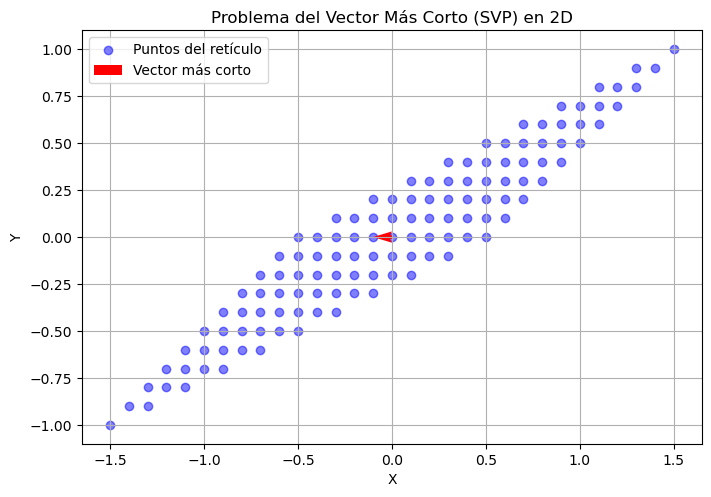

In [46]:
# PROBLEMA DEL SVP (en 2D)
# VARIABLES

dimensiones = 2  # Ahora en 2D
num_atomos = 1
num_conex = 1
limite = 5  # Limite para las combinaciones de los vectores base (por ejemplo, de -2 a 2)

# Base para el retículo (dimensiones generales)
#base = np.eye(dimensiones)  # Matriz identidad para generar base genérica en 2D
base = np.array([[0.1, 0.1],[0.2, 0.1]])

# Crear el retículo con lattpy
latt = lp.Lattice(base)

# Usar la función para crear átomos
crear_atomos(latt, num_atomos, dimensiones=dimensiones)

# Agregar conexiones de vecinos
latt.add_connections(num_conex)  # Conexión de vecinos especificada

# Construir un retículo finito de tamaño especificado
latt.build((limite,) * dimensiones)

# Generar puntos del retículo
points = latt.positions  # Coordenadas de todos los puntos del retículo

# Calculamos todos los posibles puntos del reticulo
puntos_reticulo = generar_puntos_reticulo(base, limite)

# Temporizador: Medir solo el tiempo de encontrar el vector más corto
start_time = time.time()
mejor_vector, menor_norma = shortestVector(base, limite, puntos_reticulo)
# Fin del temporizador
end_time = time.time()

# Imprimir el vector más corto con todas las coordenadas
print("Coordenadas del vector más corto:", np.array2string(mejor_vector, separator=', '))
print(f"Norma del vector más corto: {menor_norma:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más corto
print(f"Tiempo para encontrar el vector más corto: {end_time - start_time:.5f} segundos")

# Visualización en 2D del retículo y el vector más corto
plt.figure(figsize=(8, 8))

# Puntos del retículo
plt.scatter(puntos_reticulo[:, 0], puntos_reticulo[:, 1], c="blue", label="Puntos del retículo", alpha=0.5)

# Vector más corto
plt.quiver(0, 0, mejor_vector[0], mejor_vector[1], angles='xy', scale_units='xy', scale=1, color="red", label="Vector más corto", linewidth=2)

# Configurar el gráfico
plt.title("Problema del Vector Más Corto (SVP) en 2D")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(True)
plt.show()


Coordenadas del vector más corto: [ 0.2      ,  0.2339746, -0.5      ]
Norma del vector más corto: 0.59
Tiempo para encontrar el vector más corto: 8.24105 segundos


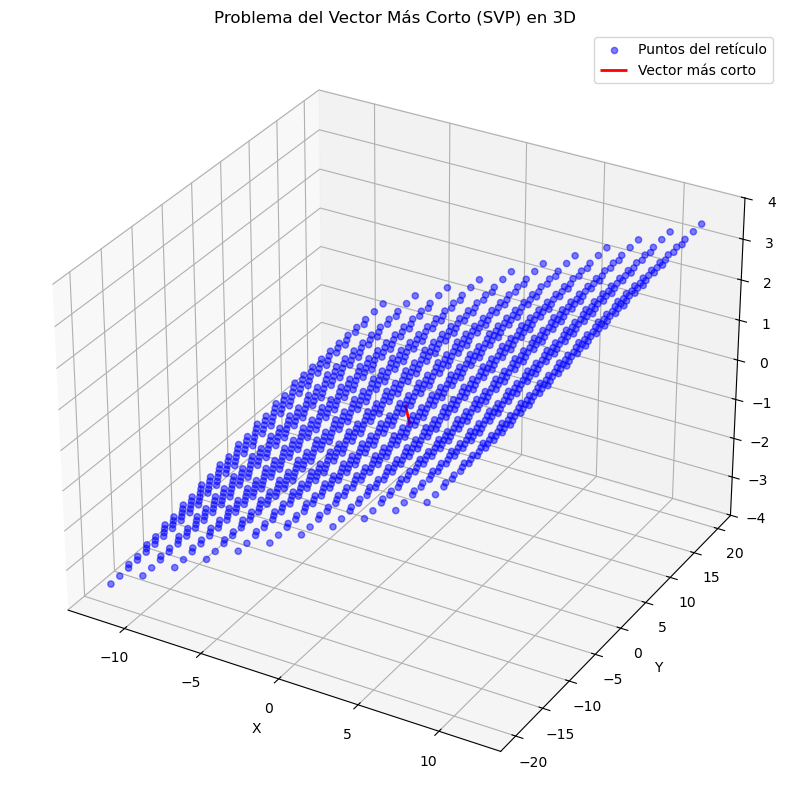

In [44]:
#PROBLEMA DEL SVP EN 3D
# VARIABLES
dimensiones = 3
num_atomos = 1
num_conex = 1
limite = 5  # Limite para las combinaciones de los vectores base (por ejemplo, de -2 a 2)

# Base para el retículo (dimensiones generales)
#base = np.eye(dimensiones)  # Matriz identidad para generar base genérica en N dimensiones
base = np.array([[1.3, 2.1, 0.1], [0.9, np.sqrt(3)/2, 0.5], [0.2, 1, 0.1]])

# Crear el retículo con lattpy
latt = lp.Lattice(base)

# Usar la función para crear átomos
crear_atomos(latt, num_atomos, dimensiones=dimensiones)

# Agregar conexiones de vecinos
latt.add_connections(num_conex)  # Conexión de vecinos especificada

# Construir un retículo finito de tamaño especificado
latt.build((limite,) * dimensiones)

# Generar puntos del retículo
points = latt.positions  # Coordenadas de todos los puntos del retículo

# Calculamos todos los posibles puntos del reticulo
puntos_reticulo = generar_puntos_reticulo(base, limite)
# Temporizador: Medir solo el tiempo de encontrar el vector más corto
start_time = time.time()
mejor_vector, menor_norma =shortestVector(base, limite, puntos_reticulo)
# Fin del temporizador
end_time = time.time()

# Imprimir el vector más corto con todas las coordenadas
print("Coordenadas del vector más corto:", np.array2string(mejor_vector, separator=', '))
print(f"Norma del vector más corto: {menor_norma:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más corto
print(f"Tiempo para encontrar el vector más corto: {end_time - start_time:.5f} segundos")

# Visualización en 3D del retículo y el vector más corto
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Puntos del retículo
ax.scatter(puntos_reticulo[:, 0], puntos_reticulo[:, 1], puntos_reticulo[:, 2], 
           c="blue", label="Puntos del retículo", alpha=0.5)

# Vector más corto
ax.quiver(0, 0, 0, 
          mejor_vector[0], mejor_vector[1], mejor_vector[2], 
          color="red", label="Vector más corto", linewidth=2, arrow_length_ratio=0.1)

# Configurar el gráfico
ax.set_title("Problema del Vector Más Corto (SVP) en 3D")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()



In [43]:
#PROBLEMA DEL SVP GENERALIZADO
# VARIABLES
dimensiones = 3
num_atomos = 1
num_conex = 1
limite = 5

# Base para el retículo (dimensiones generales)
base = np.eye(dimensiones)  # Matriz identidad para generar base genérica en N dimensiones
base = np.array([[1.3, 2.1, 0.1], [0.9, np.sqrt(3)/2, 0.5], [0.2, 1, 0.1]])  # Base de un retículo triangular 3D

# Crear el retículo con lattpy
latt = lp.Lattice(base)

# Usar la función para crear átomos
crear_atomos(latt, num_atomos, dimensiones=dimensiones)

# Agregar conexiones de vecinos
latt.add_connections(num_conex)  # Conexión de vecinos especificada

# Construir un retículo finito de tamaño especificado
latt.build((limite,) * dimensiones)

# Generar puntos del retículo
points = latt.positions  # Coordenadas de todos los puntos del retículo

# Calculamos todos los posibles puntos del reticulo
puntos_reticulo = generar_puntos_reticulo(base, limite)
# Temporizador: Medir solo el tiempo de encontrar el vector más corto
start_time = time.time()
mejor_vector, menor_norma =shortestVector(base, limite, puntos_reticulo)
# Fin del temporizador
end_time = time.time()

# Imprimir el vector más corto con todas las coordenadas
print("Coordenadas del vector más corto:", np.array2string(mejor_vector, separator=', '))
print(f"Norma del vector más corto: {menor_norma:.2f}")

# Imprimir el tiempo de ejecución del cálculo del vector más corto
print(f"Tiempo para encontrar el vector más corto: {end_time - start_time:.5f} segundos")



Coordenadas del vector más corto: [0., 0., 1.]
Norma del vector más corto: 1.00
Tiempo para encontrar el vector más corto: 0.00375 segundos


---
# 5. LWE

El Learning with Errors (LWE) es un problema matemático fundamental en criptografía post-cuántica. Se basa en la dificultad de resolver sistemas de ecuaciones lineales con ruido agregado.

Definiremos LWE de la siguiente forma:  
Sean:  
&nbsp;&nbsp;&nbsp;&nbsp;- $p$, un número primo.  
&nbsp;&nbsp;&nbsp;&nbsp;- $n$, la dimensión del espacio.  
&nbsp;&nbsp;&nbsp;&nbsp;- $χ$, una distribución de probabilidad sobre $Z_p$, que genera el ruido $e_i$.  

Se nos da un conjunto de ecuaciones tal que:  

$⟨s,a_1 ⟩ ≈_χ b_1 \ (\text{mod} \ p)$  

$⟨s,a_2 ⟩ ≈_χ b_2 \ (\text{mod} \ p)$  

⋮  

$⟨s,a_m ⟩ ≈_χ b_m \ (\text{mod} \ p)$  

O lo que es equivalente:  
$b_i=⟨s,a_i ⟩+e_i \ \text{mod} \ p; \forall i \in \mathbb{Z}_m$  

Donde:  
&nbsp;&nbsp;&nbsp;&nbsp;$s ∈ Z_p^n$ es el vector secreto que recuperar.  
&nbsp;&nbsp;&nbsp;&nbsp;$a_i ∈ Z_p^n$ son vectores seleccionados de forma uniforme.  
&nbsp;&nbsp;&nbsp;&nbsp;$e_i ∈ Z_p$ es el error añadido generado de acuerdo con $χ$.  
&nbsp;&nbsp;&nbsp;&nbsp;$b_i ∈ Z_p$ es el resultado observado.  


---- Ejemplo en 2D ----
Vector secreto real: [71 94]
Vector secreto aproximado: [0 0]


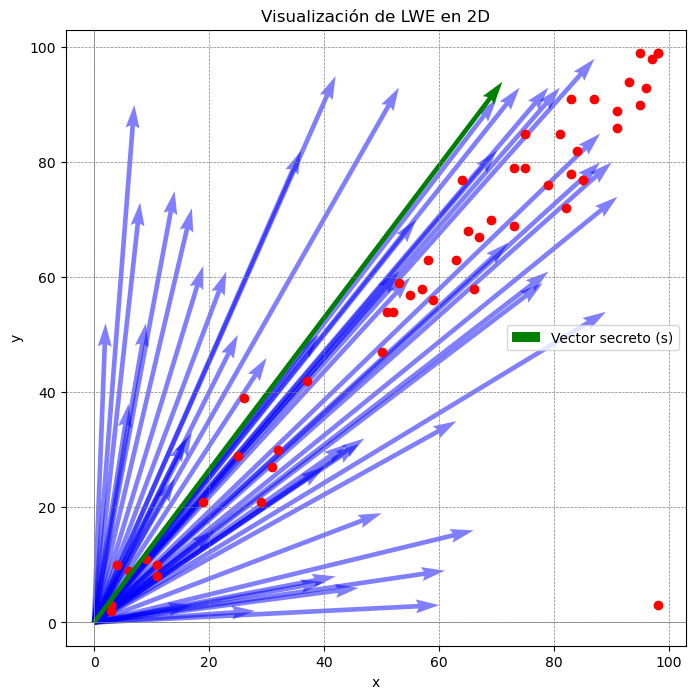

In [7]:
#PROBLEMA DEL LWE EN 2D

def generar_LWE(n, m, q, sigma):
    """
    Genera una instancia del problema de LWE.
    
    Parámetros:
    - n: número de dimensiones del espacio.
    - m: número de muestras generadas.
    - q: módulo de reducción.
    - sigma: desviación estándar del ruido gaussiano.
    
    Retorna:
    - A: matriz aleatoria de tamaño (m, n).
    - b: vector resultante (m,).
    - s: vector secreto (n,).
    """
    # Generar la matriz A de tamaño (m, n) con valores enteros en [0, q-1]
    A = np.random.randint(0, q, size=(m, n))
    
    # Generar el vector secreto s de tamaño (n,)
    s = np.random.randint(0, q, size=n)
    
    # Calcular el vector b sin ruido: b = A * s mod q
    b_sin_ruido = (A @ s) % q
    
    # Añadir ruido gaussiano a b
    ruido = np.random.normal(0, sigma, size=m)
    b = (b_sin_ruido + ruido).astype(int) % q
    
    return A, b, s

def resolver_LWE(A, b, q):
    """
    Resuelve una instancia de LWE utilizando el método de aproximación por mínimos cuadrados.
    
    Parámetros:
    - A: matriz aleatoria de tamaño (m, n).
    - b: vector resultante (m,).
    - q: módulo de reducción.
    
    Retorna:
    - s_aprox: vector secreto aproximado.
    """
    # Resolver utilizando mínimos cuadrados
    s_aprox = np.linalg.lstsq(A, b, rcond=None)[0]
    # Redondear al entero más cercano y aplicar módulo q
    s_aprox = np.round(s_aprox).astype(int) % q
    
    return s_aprox

def visualizar_LWE_2D(A, b, q, s):
    """
    Visualiza una instancia de LWE en 2D.
    
    Parámetros:
    - A: matriz aleatoria de tamaño (m, 2).
    - b: vector resultante (m,).
    - q: módulo de reducción.
    - s: vector secreto real (2,).
    """
    plt.figure(figsize=(8, 8))
    
    # Representar las muestras de A
    for i in range(A.shape[0]):
        plt.quiver(0, 0, A[i, 0], A[i, 1], angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.5)
    
    # Representar los vectores b
    for i in range(len(b)):
        punto = A[i] @ s % q
        plt.scatter(punto % q, b[i], color='red')
    
    plt.quiver(0, 0, s[0], s[1], angles='xy', scale_units='xy', scale=1, color='green', label='Vector secreto (s)')
    
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.title("Visualización de LWE en 2D")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

# Ejemplo en 2D
print("---- Ejemplo en 2D ----")
n, m, q, sigma = 2, 50, 101, 5  # Dimensiones, muestras, módulo, ruido
A, b, s = generar_LWE(n, m, q, sigma)
print(f"Vector secreto real: {s}")

s_aprox = resolver_LWE(A, b, q)
print(f"Vector secreto aproximado: {s_aprox}")

visualizar_LWE_2D(A, b, q, s)




---- Ejemplo en 3D ----
Vector secreto real: [89 85 62]
Vector secreto aproximado: [0 0 0]


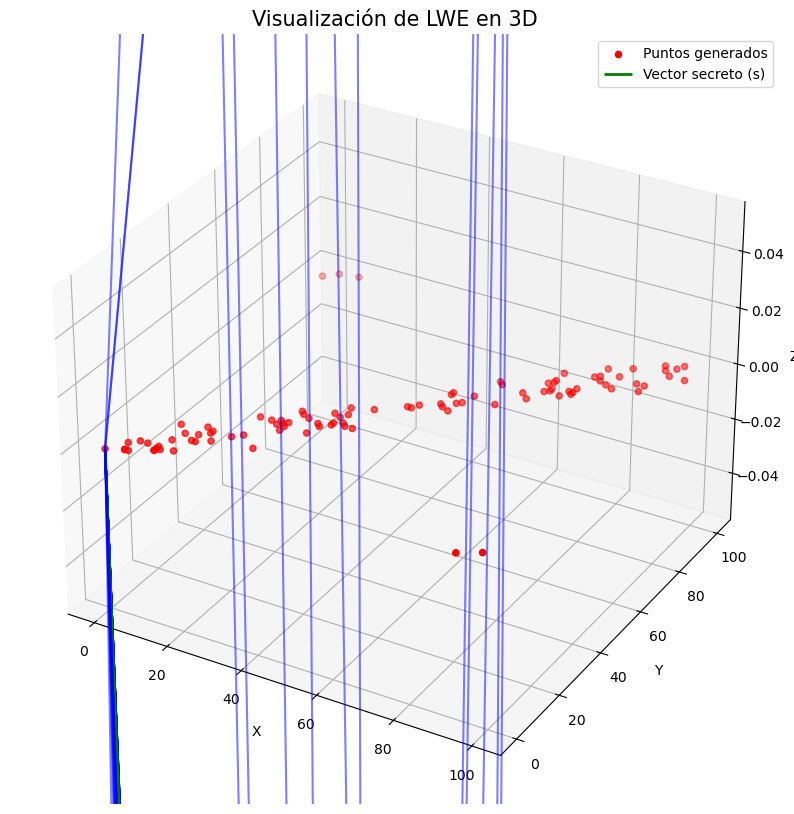

In [8]:
#PROBLEMA DEL LWE EN 3D

from mpl_toolkits.mplot3d import Axes3D

def visualizar_LWE_3D(A, b, q, s):
    """
    Visualiza una instancia de LWE en 3D.
    
    Parámetros:
    - A: matriz aleatoria de tamaño (m, 3).
    - b: vector resultante (m,).
    - q: módulo de reducción.
    - s: vector secreto real (3,).
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Representar los vectores de la matriz A
    for i in range(A.shape[0]):
        ax.quiver(0, 0, 0, A[i, 0], A[i, 1], A[i, 2], color='blue', alpha=0.5)

    # Representar los puntos asociados a b
    puntos_b = (A @ s) % q
    ax.scatter(puntos_b % q, b, color='red', label='Puntos generados')

    # Representar el vector secreto
    ax.quiver(0, 0, 0, s[0], s[1], s[2], color='green', label='Vector secreto (s)', linewidth=2)

    # Configurar el gráfico
    ax.set_title("Visualización de LWE en 3D", fontsize=15)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()

# Ejemplo en 3D
print("---- Ejemplo en 3D ----")
n, m, q, sigma = 3, 100, 101, 5  # Dimensiones, muestras, módulo, ruido
A, b, s = generar_LWE(n, m, q, sigma)
print(f"Vector secreto real: {s}")

s_aprox = resolver_LWE(A, b, q)
print(f"Vector secreto aproximado: {s_aprox}")

visualizar_LWE_3D(A, b, q, s)


In [9]:
#PROBLEMA DEL LWE GENERALIZADO
print("\n---- Ejemplo Generalizado ----")
n, m, q, sigma = 7, 200, 101, 5  # Cambiar n para aumentar la dimensionalidad
A, b, s = generar_LWE(n, m, q, sigma)
print(f"Vector secreto real: {s}")

s_aprox = resolver_LWE(A, b, q)
print(f"Vector secreto aproximado: {s_aprox}")


---- Ejemplo Generalizado ----
Vector secreto real: [72 13 46 48 68  7  1]
Vector secreto aproximado: [0 0 0 0 0 0 0]
